In [2]:
%matplotlib inline
%precision 16
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
import timeit

In [98]:
# Implement CUBE Algorithm
# Input: data array = {p1,p2,... pn}; k: ouput size
# Output: subset S of size k
def CUBE(data, k):
    """
    :Input:
     - *data* (numpy.ndarray) Our data, which is a set of d-dimensional points {p1,p2,...,pn}
     - *k* (int) The desired output size
    :Output:
     - *result_set* (numpy.ndarray) A subset of data of size k
    """
    
    # map a d-tuple (each dimension 0, ... , t-1) to index, like d digit of base t
    def tuple_2_index(tupl,t): 
        result = 0
        d = len(tupl)
        for i in range(d):
            result += tupl[i] * t ** (d-1-i)
        return int(result)
    
    # init parameters
    n = data.shape[0]
    d = data.shape[1] # dimension 
    t = np.floor((k - d + 1)**(1 /(d - 1))) # num of buckets in each dimension
    t = int(t)
    
    S = np.array([]) # contain indices of selected points
    max_index = np.argmax(data, axis=0)
    max_val = np.amax(data, axis=0) 
    
    # Step 1: add max point in first d-1 dimensions
    for i in range(d - 1): # process first p-1 dimensions
        # find point reaching max in each coordinate
        S = np.append(S,max_index[i]) 
    S = np.unique(S) # eliminate duplicate points
    
    # Step 2: bucket division
    # assign d-simensional index to each point according to bucket
    index = np.empty([n,d-1]) # for each point, the bucket is represented by a d-tuple
    
    # assign index to each point
    for i in range(n):
        for dim in range(d-1):
            c_d = max_val[dim]
            index[i,dim] = int(np.ceil(data[i,dim] / (c_d / t)) - 1)
            
    # create mapping from d-tuple (bucket) to array of indices (points inside)
    num_of_buckets = t ** (d-1)
    
    # tuple_2_indices contain all mapping from index of bucket to indices of points
    tuple_2_indices = [] # mapping: each row -- tuple, index_arr
    for bucket_index in range(num_of_buckets):
        tuple_2_indices.append([bucket_index,[]]) # init each bucket to empty array
    
    for i in range(n):
        bucket_index = tuple_2_index(index[i], t)
        #print("point %s in bucket %s" %(i,bucket_index))
        tuple_2_indices[bucket_index][1].append(i) 
    
    for bucket_index in range(num_of_buckets):
        d_max = 0
        max_index = -1
        # loop through all points in bucket, take max in dimension d
        for i in tuple_2_indices[bucket_index][1]: 
            if data[i][d-1] >= d_max:
                d_max = data[i][d-1]
                max_index = i
        if max_index >= 0: # went through loop, bucket not empty
            S = np.append(S,max_index)
            S = np.unique(S)
    S = S.astype(int)
    
    result_set = np.empty([S.shape[0],d])
    for i, index in enumerate(S):
        result_set[i] = data[index]
    return result_set

In [73]:
# Greedy Algorithm
def GREEDY(data, k):
    """
    :Input:
     - *data* (numpy.ndarray) Our data, which is a set of d-dimensional points {p1,p2,...,pn}
     - *k* (int) The desired output size
     
    :Output:
     - *S* (numpy.ndarray) A subset of data of size k
    """
    
    # initialize parameters
    S = []
    n = data.shape[0]
    d = data.shape[1]
    
    if k < d:
        print("k should be at least the number of dimensions")
        return
    
    # Find the point maximizing the first coordinate
    max_index = np.argmax(data, axis=0)
    S.append(data[max_index[0]])
    
    # Add the points which currently contributes to the maximum regret ratio
    for i in range(1, k):
        # initializing
        r_star = 0
        p_star = None
        
        # Go through every point p in data
        for p_index in range(n):
            p = data[p_index]
            Contain = False
            
            # Check if p is in S
            for s in S:
                if p.tolist() == s.tolist():
                    Contain = True
            
            # For p in data but not in S
            if Contain == False:
                # Compute the regret ratio
                rr = 0
                
                # What we are minimizing is -x (find max x)
                c = np.zeros(d+1).tolist()
                c[0] = -1.0
                
                # Subject to the following equality
                b_eq = 1.0
                A_eq = [[0.0]]
                for j in range (d):
                    A_eq[0].append(p[j])
                
                # Subject to the following inequality
                b_ub = np.zeros(len(S)).tolist()
                A_ub = []
                for p_prime in S:
                    A_ub.append([])
                    A_ub[-1].append(1.0)
                    for j in range(d):
                         A_ub[-1].append(-p[j] + p_prime[j])
                
                # Solve the LP
                result = linprog(c,A_ub, b_ub, A_eq, b_eq).x
                
                # If we can find such x
                if type(result) == np.ndarray:
                    rr = result[0]
                    if r_star < rr:
                        r_star = rr
                        p_star = p
                    
        if r_star == 0:
            return S
        else:
            S.append(p_star)
    
    # Convert S from list to array
    S = np.array(S)
    return S

In [74]:
from scipy.spatial import ConvexHull

def normalize_data(data): # normalize all data onto [0,1]
    max_val = np.amax(data, axis=0) # norm for each dimension
    max_index = np.argmax(data, axis=0)
    N = data.shape[0]
    d = data.shape[1]
    for i in range(N):
        for j in range(d):
            data[i][j] = data[i][j]/max_val[j]
    return data

# preprocess data for happy points
def hp_preprocessing(data):
    """
    :Input:
     - *data* (numpy.ndarray) Our data, which is a set of d-dimensional points {p1,p2,...,pn}
     
    :Output:
     - *num_points* (int): size of data after preprocessing
     - *hp_points* (numpy.ndarray) data after preprocessed 
    """
    
    # for any combinations of two points, if p is subjugated by p', then delete p from list
    # Method: take convex hull of p, p', VC, if p not in point set of convex hull, 
    # then p inside convex hull, subjugated by p'
    N = data.shape[0] # total number of points
    num_points = 0
    d = data.shape[1] # dimension of data
    point_bool = np.ones(N) # boolean array, init with all 1
    hp_points = [] # store output set of happy points
    
    data = normalize_data(data)
    for i in range(N):
        for j in range(N):
            if i == j:
                continue
                
            # consider p' = data[i], p = data[j]
            # VC contains all virtual corner points
            pointList = np.empty([d+3, d])
            VC = np.eye(d)
            pointList[0] = np.zeros(d)
            pointList[1:d+1, 0:d] = VC
            pointList[d + 1] = data[i]
            pointList[d + 2] = data[j]
            j_index = d + 2
            hull = ConvexHull(pointList)
            hull_indices = hull.vertices
            
            # p not on convex hull, then p is subjugated
            if not j_index in hull_indices: 
                point_bool[j] = 0
                
    # construct output list of happy points
    for i in range(N):
        if point_bool[i] == 1:
            hp_points.append(data[i])
            num_points = num_points + 1
    hp_points = np.array(hp_points)
    
    return num_points, hp_points

def GeoGreedy(data, k):
    num_hp, hp_points = hp_preprocessing(data)
    S = GREEDY(hp_points, k)
    return S

In [75]:
def new_mrr (data, S):
# Go through every point p in data
    # initialize parameters
    n = data.shape[0]
    d = data.shape[1]

    max_regret = 0
    
    for p in data:
        # What we are minimizing is -x (find max x)
        c = np.zeros(d+1).tolist()
        c[0] = -1.0
                
        # Subject to the following equality
        b_eq = 1.0
        A_eq = [[0.0]]
        for j in range (d):
            A_eq[0].append(p[j])
                
        # Subject to the following inequality
        b_ub = np.zeros(len(S)).tolist()
        A_ub = []
            
        for p_prime in S:
            A_ub.append([])
            A_ub[-1].append(1.0)
            for j in range(d):
                A_ub[-1].append(-p[j] + p_prime[j])
                
        # Solve the LP
        result = linprog(c,A_ub, b_ub, A_eq, b_eq).x
        # If we can find such x
        if type(result) == np.ndarray:
            if result[0] > max_regret:
                max_regret = result[0]
    return max_regret

In [90]:
# Process Input: data stored in array data
data = np.genfromtxt('Pokemon.csv',delimiter=",")
data = np.delete(data, 0, 1)
data_6D = np.delete(data, 0, 1)
data_5D = np.delete(data_6D, 0, 1)
data_4D = np.delete(data_5D, 0, 1)
data_3D = np.delete(data_4D, 0, 1)
data_2D = np.delete(data_3D, 0, 1)
max_index = np.argmax(data, axis=0)
max_val = np.amax(data, axis=0) 
print(data_4D)
print(data.shape)

[[  49.   65.   65.   45.]
 [  63.   80.   80.   60.]
 [  83.  100.  100.   80.]
 ..., 
 [  60.  150.  130.   70.]
 [  60.  170.  130.   80.]
 [ 120.  130.   90.   70.]]
(800, 7)


In [ ]:
# Process Input: data stored in array data
data = np.genfromtxt('Pokemon.csv',delimiter=",")
data = np.delete(data, 0, 1)
data_6D = np.delete(data, 0, 1)
data_5D = np.delete(data_6D, 0, 1)
data_4D = np.delete(data_5D, 0, 1)
data_3D = np.delete(data_4D, 0, 1)
data_2D = np.delete(data_3D, 0, 1)
max_index = np.argmax(data, axis=0)
max_val = np.amax(data, axis=0) 
print(data_4D)

In [78]:
# Cube run time 
Cube_run_time_arr = np.empty(5) # 2d, 3d, 4d, 5d, 6d

start_time = timeit.default_timer()
S_Cube_2D = CUBE(data_2D, 10) 
Cube_run_time_arr[0] = timeit.default_timer() - start_time

start_time = timeit.default_timer()
S_Cube_3D = CUBE(data_3D, 10) 
Cube_run_time_arr[1] = timeit.default_timer() - start_time

start_time = timeit.default_timer()
S_Cube_4D = CUBE(data_4D, 10) 
Cube_run_time_arr[2] = timeit.default_timer() - start_time

start_time = timeit.default_timer()
S_Cube_5D = CUBE(data_5D, 10) 
Cube_run_time_arr[3] = timeit.default_timer() - start_time

start_time = timeit.default_timer()
S_Cube_6D = CUBE(data_6D, 10) 
Cube_run_time_arr[4] = timeit.default_timer() - start_time

print(Cube_run_time_arr)

# Cube MRR 
Cube_regret_arr = np.empty(5)
Cube_regret_arr[0] = new_mrr(data_2D, S_Cube_2D)
Cube_regret_arr[1] = new_mrr(data_3D, S_Cube_3D)
Cube_regret_arr[2] = new_mrr(data_4D, S_Cube_4D)
Cube_regret_arr[3] = new_mrr(data_5D, S_Cube_5D)
Cube_regret_arr[4] = new_mrr(data_6D, S_Cube_6D)

print(Cube_regret_arr)

#S_Greed = GREEDY(hp_points, 10)
#print("Greedy")
#print(maximum_regret(data, S_Greed))

[ 0.0048760159988888  0.0072124050348066  0.0095575509476475
  0.0137146470369771  0.0163524830131792]
[ 0.                  0.1181965881397238  0.1182958477508651
  0.1387956122677412  0.1387956122677412]


In [81]:
# Preprocessing
num_hp_2D, hp_points_2D = hp_preprocessing(data_2D)
num_hp_3D, hp_points_3D = hp_preprocessing(data_3D)
num_hp_4D, hp_points_4D = hp_preprocessing(data_4D)
num_hp_5D, hp_points_5D = hp_preprocessing(data_5D)
num_hp_6D, hp_points_6D = hp_preprocessing(data_6D)

In [82]:
Greedy_runtime_arr = np.empty(5) # 2d, 3d, 4d, 5d, 6d
GeoGreedy_runtime_arr = np.empty(5)
Greedy_regret_arr = np.empty(5)

# Record Running Time for GeoGreedy
start_time = timeit.default_timer()
S_GeoGreedy_2D = GREEDY(hp_points_2D, 10) 
GeoGreedy_runtime_arr[0] = timeit.default_timer() - start_time

start_time = timeit.default_timer()
S_GeoGreedy_3D = GREEDY(hp_points_3D, 10) 
GeoGreedy_runtime_arr[1] = timeit.default_timer() - start_time

start_time = timeit.default_timer()
S_GeoGreedy_4D = GREEDY(hp_points_4D, 10) 
GeoGreedy_runtime_arr[2] = timeit.default_timer() - start_time

start_time = timeit.default_timer()
S_GeoGreedy_5D = GREEDY(hp_points_5D, 10) 
GeoGreedy_runtime_arr[3] = timeit.default_timer() - start_time

start_time = timeit.default_timer()
S_GeoGreedy_6D = GREEDY(hp_points_6D, 10) 
GeoGreedy_runtime_arr[4] = timeit.default_timer() - start_time

In [83]:
print(GeoGreedy_runtime_arr)

[ 0.0128105349722318  0.1453202869743109  0.8713274140027352
  1.8878894139779732  3.6967379450215958]


In [84]:
# Record Running time for Greedy
start_time = timeit.default_timer()
S_Greedy_2D = GREEDY(data_2D, 10) 
Greedy_runtime_arr[0] = timeit.default_timer() - start_time

start_time = timeit.default_timer()
S_Greedy_3D = GREEDY(data_3D, 10) 
Greedy_runtime_arr[1] = timeit.default_timer() - start_time

start_time = timeit.default_timer()
S_Greedy_4D = GREEDY(data_4D, 10) 
Greedy_runtime_arr[2] = timeit.default_timer() - start_time

start_time = timeit.default_timer()
S_Greedy_5D = GREEDY(data_5D, 10) 
Greedy_runtime_arr[3] = timeit.default_timer() - start_time

start_time = timeit.default_timer()
S_Greedy_6D = GREEDY(data_6D, 10) 
Greedy_runtime_arr[4] = timeit.default_timer() - start_time

print(Greedy_runtime_arr)


[  3.6249739549821243   6.6192894009873271  10.4798209560103714
   8.1089237409760244  12.7133184269769117]


In [85]:
# Record MRR for Greedy
Greedy_regret_arr[0] = new_mrr(data_2D, S_GeoGreedy_2D)
Greedy_regret_arr[1] = new_mrr(data_3D, S_GeoGreedy_3D)
Greedy_regret_arr[2] = new_mrr(data_4D, S_GeoGreedy_4D)
Greedy_regret_arr[3] = new_mrr(data_5D, S_GeoGreedy_5D)
Greedy_regret_arr[4] = new_mrr(data_6D, S_GeoGreedy_6D)

print(Greedy_regret_arr)

[ 0.                  0.                  0.0195011337868481
  0.0353774428559505  0.0783075089392134]


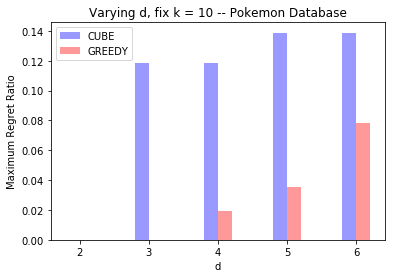

In [94]:
# varying d = 6, n = all
mrrg = [ 0. ,                 0.     ,             0.0195011337868481,
  0.0353774428559505,  0.0783075089392134]
mrrc = [ 0.  ,                0.1181965881397238 , 0.1182958477508651,
  0.1387956122677412,  0.1387956122677412]

x = [2,3,4,5,6]   
index = np.arange(len(x))
bar_width = 0.2
opacity = 0.4
  
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
# plot

plt.bar(index, mrrc, bar_width,
                 alpha=opacity,
                 color='b',
                 label='CUBE')

plt.bar(index + bar_width, mrrg, bar_width,
                 alpha=opacity,
                 color='r',
                 label='GREEDY')

plt.xticks(index + bar_width / 2, x)
axes.legend()

axes.set_title("Varying d, fix k = 10 -- Pokemon Database")
axes.set_xlabel("d")
axes.set_ylabel("Maximum Regret Ratio")

plt.show()

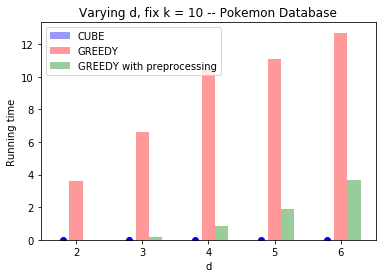

In [13]:
# varying d = 6, n = all
# backup data
G_runtime = [  3.6249739549821243,   6.6192894009873271,  10.4798209560103714,
   11.1089237409760244,  12.7133184269769117]
Geo_runtime = [ 0.0128105349722318,  0.1453202869743109,  0.8713274140027352,
  1.8878894139779732,  3.6967379450215958]
Cube_runtime = [ 0.0049782060086727,  0.0065547170233913,  0.0111810489906929,
  0.0115836900076829,  0.0146438719821163]


x = [2,3,4,5,6]   
index = np.arange(len(x))
bar_width = 0.2
opacity = 0.4

    
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
# plot

plt.bar(index - bar_width, Cube_runtime, bar_width,
                 alpha=opacity,
                 color='b',
                 label='CUBE')

plt.bar(index, G_runtime, bar_width,
                 alpha=opacity,
                 color='r',
                 label='GREEDY')

plt.bar(index + bar_width, Geo_runtime, bar_width,
                 alpha=opacity,
                 color='g',
                 label='GREEDY with preprocessing')
plt.plot(index - bar_width, Cube_runtime, 'bo')

plt.xticks(index, x)
axes.legend()

axes.set_title("Varying d, fix k = 10 -- Pokemon Database")
axes.set_xlabel("d")
axes.set_ylabel("Running time")

plt.show()

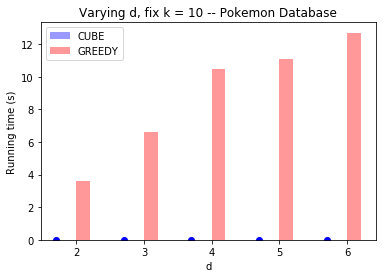

In [11]:
# varying d = 6, n = all
# backup data
Cube_runtime = [ 0.0049782060086727,  0.0065547170233913,  0.0111810489906929,
  0.0115836900076829,  0.0146438719821163]
G_runtime = [  3.6249739549821243,   6.6192894009873271,  10.4798209560103714,
   11.1089237409760244,  12.7133184269769117]

x = [2,3,4,5,6]   
index = np.arange(len(x))
bar_width = 0.2
opacity = 0.4

    
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
# plot
plt.bar(index, Cube_runtime, bar_width,
                 alpha=opacity,
                 color='b',
                 label='CUBE')

plt.bar(index + bar_width, G_runtime, bar_width,
                 alpha=opacity,
                 color='r',
                 label='GREEDY')

plt.plot(index - bar_width, Cube_runtime, 'bo')

plt.xticks(index + 0.5 * bar_width, x)
axes.legend()

axes.set_title("Varying d, fix k = 10 -- Pokemon Database")
axes.set_xlabel("d")
axes.set_ylabel("Running time (s)")

plt.show()

In [ ]:
# varying k, d = 6, n = all
x = []
mrrg = []
mrrc = []

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

for i in range(2,9):
    x.append(3*i)
    S_Greed = GREEDY(data_6D, 3*i)
    S_Cube = CUBE(data_6D, 3*i)
    mrrg.append(new_mrr(data_6D, S_Greed))
    mrrc.append(new_mrr(data_6D, S_Cube))

print("Cube:")
print(mrrc)
print("Greedy:")
print(mrrg)

# plot
axes.plot(x, mrrg, 'ro')
axes.plot(x, mrrc, 'bo')
    
axes.set_xlabel("k")
axes.set_ylabel("Maximum regret ratio")

plt.show()

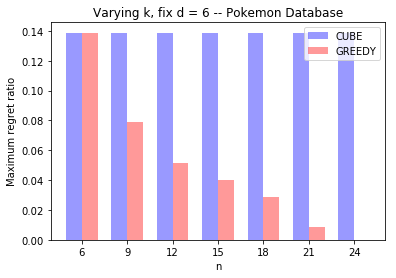

In [96]:
# Backup Data
# varying k, d = 6, n = all
mrrc = [0.13879561226774118, 0.13879561226774118, 0.13879561226774118, 0.13879561226774118, 
        0.13879561226774118, 0.13879561226774118, 0.13879561226774118]
mrrg = [0.13879561226774118, 0.078900709219858145, 0.051352276617596719, 0.039981485228032104, 
        0.028562947182775647, 0.0082980933303660343, 1.4442365862422971e-18]


x = []
for i in range(2,9):
    x.append(3*i)
    
index = np.arange(len(x))
bar_width = 0.35
opacity = 0.4

    
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
# plot

plt.bar(index, mrrc, bar_width,
                 alpha=opacity,
                 color='b',
                 label='CUBE')

plt.bar(index + bar_width, mrrg, bar_width,
                 alpha=opacity,
                 color='r',
                 label='GREEDY')

plt.xticks(index + bar_width / 2, x)
axes.legend()

axes.set_title("Varying k, fix d = 6 -- Pokemon Database")
axes.set_xlabel("n")
axes.set_ylabel("Maximum regret ratio")

plt.show()

In [ ]:
# varying n, fit d = 6, k = 10
x = [100,200,300,400,500,600]
mrrg = []
mrrc = []

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

for i in x:
    data = []
    for j in range(i):
        data.append(data_6D[j])
    data = np.array(data)

    S_Greed = GREEDY(data, 10)
    S_Cube = CUBE(data, 10)
    mrrg.append(new_mrr(data, S_Greed))
    mrrc.append(new_mrr(data, S_Cube))
    

print("Cube:")
print(mrrc)
print("Greedy:")
print(mrrg)

# plot
axes.plot(x, mrrg, 'ro')
axes.plot(x, mrrc, 'bo')
    
axes.set_xlabel("n")
axes.set_ylabel("Maximum regret ratio")

plt.show()

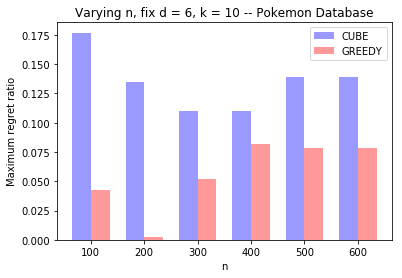

In [97]:
# Backup Data
# varying n, fit d = 6, k = 10
mrrc = [0.17687408133268007, 0.13451327433628318, 0.11021388040157137, 0.11021388040157137, 
 0.13879561226774118, 0.13879561226774118]
mrrg = [0.042180137731061974, 0.0022779043280182236, 0.051597051597051594, 0.081624044292117059, 
 0.07830750893921333, 0.07830750893921333]

index = np.arange(6)
bar_width = 0.35
opacity = 0.4

x = [100,200,300,400,500,600]
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
# plot

plt.bar(index, mrrc, bar_width,
                 alpha=opacity,
                 color='b',
                 label='CUBE')

plt.bar(index + bar_width, mrrg, bar_width,
                 alpha=opacity,
                 color='r',
                 label='GREEDY')

plt.xticks(index + bar_width / 2, ('100', '200', '300', '400', '500', '600'))
axes.legend()

axes.set_title("Varying n, fix d = 6, k = 10 -- Pokemon Database")
axes.set_xlabel("n")
axes.set_ylabel("Maximum regret ratio")

plt.show()